# 4.10: Optimize simulated rhythmic response parameters

This example demonstrates how to optimize the power spectral density (PSD)
of a current dipole signal with significant alpha and beta spectral
components.

In [1]:
# Authors: Carolina Fernandez <cxf418@miami.edu>

import matplotlib.pyplot as plt

Let us import `hnn_core`

In [2]:
from hnn_core import (MPIBackend, jones_2009_model, simulate_dipole)

# The number of cores may need modifying depending on your current machine.
n_procs = 10

--No graphics will be displayed.


First, we define a function that will tell the optimization routine how to
modify the network drive parameters. The function will take in the 
[Network](https://jonescompneurolab.github.io/hnn-core/stable/generated/hnn_core.Network.html#hnn_core.Network)
object with no attached drives, and a dictionary of the parameters we wish to
optimize.

In [3]:
def set_params(net, params):

    # Proximal (alpha)
    weights_ampa_p = {'L2_pyramidal': params['alpha_prox_weight'],
                      'L5_pyramidal': 4.4e-5}
    syn_delays_p = {'L2_pyramidal': 0.1, 'L5_pyramidal': 1.}

    net.add_bursty_drive('alpha_prox',
                         tstart=params['alpha_prox_tstart'],
                         burst_rate=params['alpha_prox_burst_rate'],
                         burst_std=params['alpha_prox_burst_std'],
                         numspikes=2,
                         spike_isi=10,
                         n_drive_cells=10,
                         location='proximal',
                         weights_ampa=weights_ampa_p,
                         synaptic_delays=syn_delays_p)

    # Distal (beta)
    weights_ampa_d = {'L2_pyramidal': params['alpha_dist_weight'],
                      'L5_pyramidal': 4.4e-5}
    syn_delays_d = {'L2_pyramidal': 5., 'L5_pyramidal': 5.}

    net.add_bursty_drive('alpha_dist',
                         tstart=params['alpha_dist_tstart'],
                         burst_rate=params['alpha_dist_burst_rate'],
                         burst_std=params['alpha_dist_burst_std'],
                         numspikes=2,
                         spike_isi=10,
                         n_drive_cells=10,
                         location='distal',
                         weights_ampa=weights_ampa_d,
                         synaptic_delays=syn_delays_d)

Then, we define the constraints.

The constraints must be a dictionary of tuples where the first value in each
tuple is the lower bound and the second value is the upper bound for the
corresponding parameter.

The following synaptic weight parameter ranges (units of micro-siemens)
were chosen so as to keep the model in physiologically realistic regimes.



In [4]:
constraints = dict()
constraints.update({'alpha_prox_weight': (4.4e-5, 6.4e-5),
                    'alpha_prox_tstart': (45, 55),
                    'alpha_prox_burst_rate': (1, 30),
                    'alpha_prox_burst_std': (10, 30),
                    'alpha_dist_weight': (4.4e-5, 6.4e-5),
                    'alpha_dist_tstart': (45, 55),
                    'alpha_dist_burst_rate': (1, 30),
                    'alpha_dist_burst_std': (10, 30)})

Now we define and fit the optimizer.



In [ ]:
from hnn_core.optimization import Optimizer

tstop = 300
scale_factor = 3000
smooth_window_len = 20

net = jones_2009_model()
optim = Optimizer(net, tstop=tstop, constraints=constraints,
                  set_params=set_params, obj_fun='maximize_psd')

# 8-15 Hz (alpha) and 15-30 Hz (beta) are the frequency bands whose
# power we wish to maximize in a ratio of 1 to 2.
with MPIBackend(n_procs=n_procs, mpi_cmd='mpiexec'):
    optim.fit(f_bands=[(9, 11), (19, 21)], relative_bandpower=(1, 2),
              scale_factor=scale_factor, smooth_window_len=smooth_window_len)

Finally, we can plot the optimized dipole, power spectral density (PSD), and
convergence plot.



MPI will run 1 trial(s) sequentially by distributing network neurons over 10 processes.
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/opt/anaconda3/envs/hc12/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools

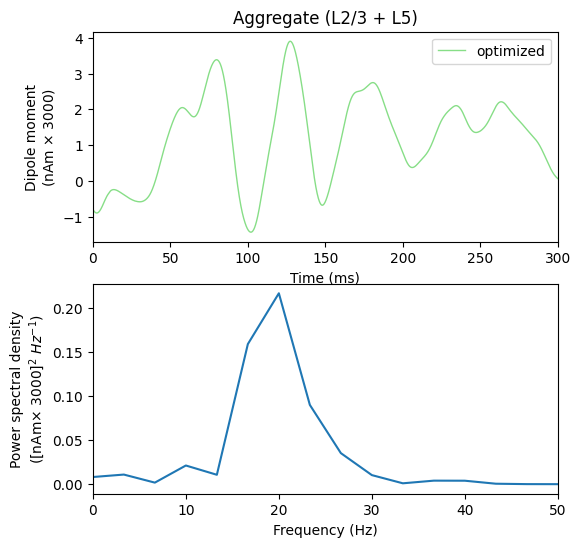

In [6]:
from hnn_core.viz import plot_psd

with MPIBackend(n_procs=n_procs, mpi_cmd='mpiexec'):
    opt_dpl = simulate_dipole(optim.net_, tstop=tstop, n_trials=1)[0]
opt_dpl.scale(scale_factor)
opt_dpl.smooth(smooth_window_len)

fig, axes = plt.subplots(2, 1, figsize=(6, 6))

# plot dipole
opt_dpl.plot(ax=axes[0], layer='agg', show=False, color='tab:green')
axes[0].legend(['optimized'])

# plot psd
plot_psd(opt_dpl, fmax=50, ax=axes[1], show=False)
plt.show()

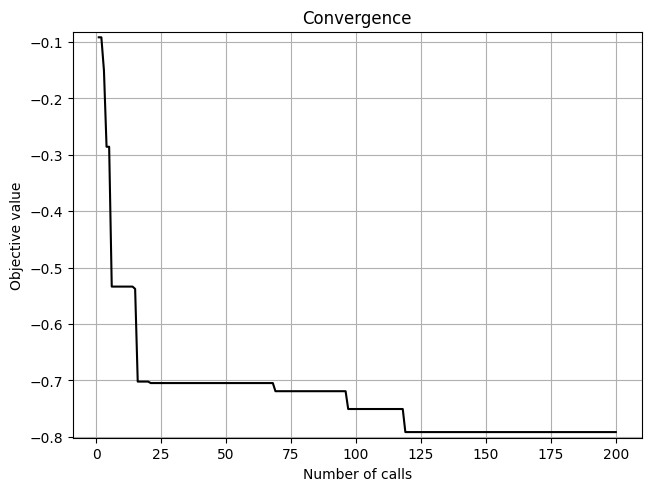

In [7]:
# convergence
fig1 = optim.plot_convergence(show=False)
plt.show()